In [1]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)

In [2]:
#合约代码
code = 'rb1805'
exchange = 'SHFE'
vtCode = '.'.join([code, exchange])
startDate = '20170516'
endDate = datetime.now().strftime('%Y%m%d')
#endDate = '20170601'

In [9]:
'''
课程策略
'''
class BollChannelStrategy(CtaTemplate):
    """基于布林通道的交易策略"""
    className = 'BollChannelStrategy'
    author = u'用Python的交易员'

    # 策略参数
    bollWindow = 18                     # 布林通道窗口数
    bollDev = 3.4                       # 布林通道的偏差
    cciWindow = 10                      # CCI窗口数
    atrWindow = 30                      # ATR窗口数
    slMultiplier = 5.2                  # 计算止损距离的乘数
    initDays = 10                       # 初始化数据所用的天数
    fixedSize = 1                       # 每次交易的数量

    # 策略变量
    bollUp = 0                          # 布林通道上轨
    bollDown = 0                        # 布林通道下轨
    cciValue = 0                        # CCI指标数值
    atrValue = 0                        # ATR指标数值
    
    intraTradeHigh = 0                  # 持仓期内的最高点
    intraTradeLow = 0                   # 持仓期内的最低点
    longStop = 0                        # 多头止损
    shortStop = 0                       # 空头止损

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'bollWindow',
                 'bollDev',
                 'cciWindow',
                 'atrWindow',
                 'slMultiplier',
                 'initDays',
                 'fixedSize']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'bollUp',
               'bollDown',
               'cciValue',
               'atrValue',
               'intraTradeHigh',
               'intraTradeLow',
               'longStop',
               'shortStop']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(BollChannelStrategy, self).__init__(ctaEngine, setting)
        
        self.bm = BarManager(self.onBar, 15, self.onXminBar)        # 创建K线合成器对象
        self.am = ArrayManager()
        
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）""" 
        self.bm.updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.bm.updateBar(bar)
    
    #----------------------------------------------------------------------
    def onXminBar(self, bar):
        """收到X分钟K线"""
        # 全撤之前发出的委托
        self.cancelAll()
    
        # 保存K线数据
        am = self.am
        
        am.updateBar(bar)
        
        if not am.inited:
            return
        
        # 计算指标数值
        self.bollUp, self.bollDown = am.boll(self.bollWindow, self.bollDev)
        self.cciValue = am.cci(self.cciWindow)
        self.atrValue = am.atr(self.atrWindow)
        
        # 判断是否要进行交易
    
        # 当前无仓位，发送开仓委托
        if self.pos == 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = bar.low            
            
            if self.cciValue > 0:
                self.buy(self.bollUp, self.fixedSize, True)
                
            elif self.cciValue < 0:
                self.short(self.bollDown, self.fixedSize, True)
    
        # 持有多头仓位
        elif self.pos > 0:
            self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
            self.intraTradeLow = bar.low
            self.longStop = self.intraTradeHigh - self.atrValue * self.slMultiplier
            
            self.sell(self.longStop, abs(self.pos), True)
    
        # 持有空头仓位
        elif self.pos < 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = min(self.intraTradeLow, bar.low)
            self.shortStop = self.intraTradeLow + self.atrValue * self.slMultiplier
            
            self.cover(self.shortStop, abs(self.pos), True)
    
        # 发出状态更新事件
        self.putEvent()        

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [13]:
'''
我的策略
'''
class BollChannelStrategy(CtaTemplate):
    """基于布林通道的交易策略"""
    className = 'BollChannelStrategy'
    author = u'loe'

    # 策略参数
    bollWindow = 18                     # 布林通道窗口数
    bollDev = 3.4                       # 布林通道的偏差
    cciWindow = 10                      # CCI窗口数
    atrWindow = 30                      # ATR窗口数
    slMultiplier = 5.2                  # 计算止损距离的乘数
    initDays = 10                       # 初始化数据所用的天数
    fixedSize = 1                       # 每次交易的数量

    # 策略变量
    bollUp = 0                          # 布林通道上轨
    bollDown = 0                        # 布林通道下轨
    cciValue = 0                        # CCI指标数值
    atrValue = 0                        # ATR指标数值
    
    intraTradeHigh = 0                  # 持仓期内的最高点
    intraTradeLow = 0                   # 持仓期内的最低点
    longStop = 0                        # 多头止损
    shortStop = 0                       # 空头止损

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'bollWindow',
                 'bollDev',
                 'cciWindow',
                 'atrWindow',
                 'slMultiplier',
                 'initDays',
                 'fixedSize']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'bollUp',
               'bollDown',
               'cciValue',
               'atrValue',
               'intraTradeHigh',
               'intraTradeLow',
               'longStop',
               'shortStop']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(BollChannelStrategy, self).__init__(ctaEngine, setting)
        
        self.bm = BarManager(self.onBar, 15, self.onXminBar)        # 创建K线合成器对象
        self.am = ArrayManager()
        
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）""" 
        self.bm.updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.bm.updateBar(bar)
    
    #----------------------------------------------------------------------
    def onXminBar(self, bar):
        """收到X分钟K线"""
        # 全撤之前发出的委托
        self.cancelAll()
    
        # 保存K线数据
        am = self.am
        
        am.updateBar(bar)
        
        if not am.inited:
            return
        
        # 计算指标数值
        self.bollUp, self.bollDown = am.boll(self.bollWindow, self.bollDev)
        self.cciValue = am.cci(self.cciWindow)
        self.atrValue = am.atr(self.atrWindow)
        
        #'''
        if self.trading:
            print '='*26, bar.datetime, '='*26
            
            print 'bollUp', ' '*2, self.bollUp
            
            print 'bollDown', ' '*2, self.bollDown
            
            print 'close', ' '*2, bar.close
            
            print 'cciValue', ' '*2, self.cciValue
            
            print 'atrValue', ' '*2, self.atrValue, '\n'
        #'''
        
        # 判断是否要进行交易
    
        # 当前无仓位，发送开仓委托
        if self.pos == 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = bar.low            
            
            if self.cciValue > 0:
                self.buy(self.bollUp, self.fixedSize, True)
                
            elif self.cciValue < 0:
                self.short(self.bollDown, self.fixedSize, True)
    
        # 持有多头仓位
        elif self.pos > 0:
            self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
            self.intraTradeLow = bar.low
            self.longStop = self.intraTradeHigh - self.atrValue * self.slMultiplier
            
            self.sell(self.longStop, abs(self.pos), True)
    
        # 持有空头仓位
        elif self.pos < 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = min(self.intraTradeLow, bar.low)
            self.shortStop = self.intraTradeLow + self.atrValue * self.slMultiplier
            
            self.cover(self.shortStop, abs(self.pos), True)
    
        # 发出状态更新事件
        self.putEvent()        

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        #'''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos
        if not self.pos :
            print '='*60
        print '\n'
        #'''

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2017-12-08 17:48:10.401000	开始载入数据
2017-12-08 17:48:12.719000	载入完成，数据量：1701307
2017-12-08 17:48:12.719000	开始回测
2017-12-08 17:48:12.865000	策略初始化完成
2017-12-08 17:48:12.865000	策略启动完成
2017-12-08 17:48:12.865000	开始回放数据
========================== 2017-05-26 09:00:00 ==========================
bollUp    2933.83113975
bollDown    2791.72441581
close    2835.0
cciValue    -169.811320755
atrValue    14.2511318785 

========================== 2017-05-26 09:15:00 ==========================
bollUp    2932.59801172
bollDown    2785.06865494
close    2821.0
cciValue    -252.302025783
atrValue    14.6892693693 

========================== 2017-05-26 09:30:00 ==========================
bollUp    2927.93997543
bollDown    2781.3933579
close    2820.0
cciValue    -172.732524552
atrValue    14.8255694132 

========================== 2017-05-26 09:45:00 ==========================
bollUp    2923.68094209
bollDown    2777.09683569
close    2814.0
cciValue    -140.808344198
atrValue    14.6143523839 

========

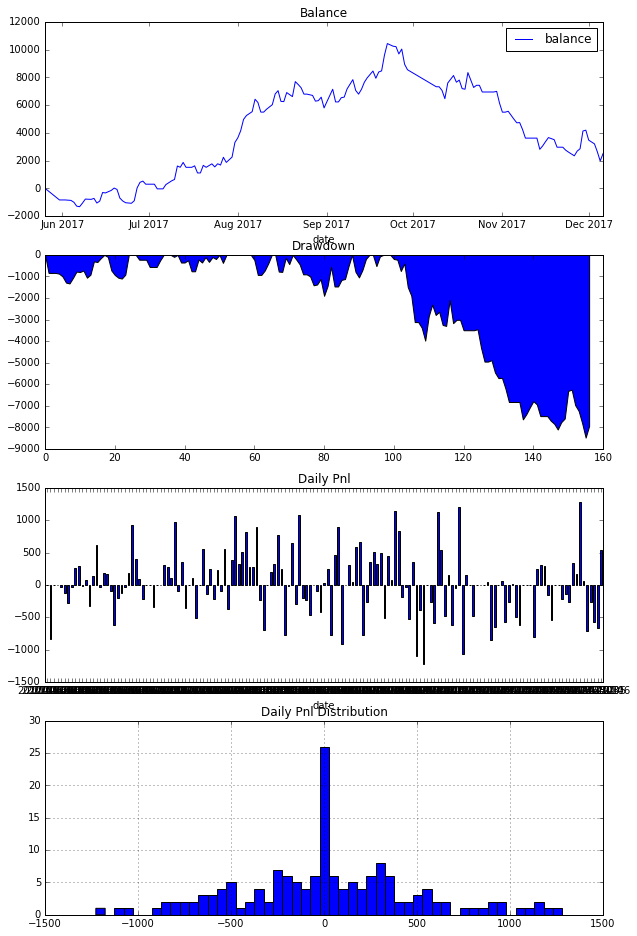

In [14]:
'''
回测
'''

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = BollChannelStrategy.initDays) #这里的initDays是真正起作用的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每手数量
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(0) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(BollChannelStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()